# Vinho Verde: Wine Quality Analysis

## Introduction

Wine is an alcoholic beverage made from the fermentation of grape juice, with many factors determining its quality. Wine without any acidity is “flat”, hence a fixed acidity level. Volatile acidity is the measure of acetic acid in wine, if it is above a threshold the wine will taste sour, citric acid enhances the flavour, residual sugar in wine is leftover sugar from grapes; higher sugar levels increase sweetness, and chloride contributes to saltiness in wine. 

**The main question we are answering is: What produces the highest quality of wine given our predictors, (VA, citric acidity, residual sugar, chloride, sulfur dioxide, and sulphate)?**

The dataset used is collected by Paulo Cortez, from the University of Minho in Portugal. He, along with A. Cerdeira, F. Almeida, T. Matos, and J. Reis, Viticulture Commission of the Vinho Verde Region(CVRVV), Porto, Portugal collected data about the Vinho Verde wines from Portugal. This dataset (from 2009) observes the physicochemical qualities of the wine (acidity, sulphates, etc.), and excludes grape type, wine brand, or other subjective qualities.

**Citation:**

P. Cortez, A. Cerdeira, F. Almeida, T. Matos, and J. Reis.
Modeling wine preferences by data mining from physicochemical properties. In Decision Support Systems, Elsevier, 47(4):547-553, 2009

## Preliminary exploratory data analysis

In [34]:
library(tidyverse)
library(digest)
library(repr)
library(tidymodels)
library(cowplot)
options(repr.matrix.max.rows = 4)
set.seed(1)

We use the `read_csv2()` function to read the file from the web.

In [35]:
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
wine_red <- read_csv2(url)

ℹ Using "','" as decimal and "'.'" as grouping mark. Use `read_delim()` for more control.

Warning message:
“One or more parsing issues, see `problems()` for details”
Rows: 1599 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ";"
chr (5): volatile acidity, citric acid, chlorides, density, sulphates
dbl (2): total sulfur dioxide, quality

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


We clean the column names to remove spaces using `make.names`, then change the datatypes of columns to dbl using `mutate()` and `as.double()` and finally remove the columns we dont wish to use using `select()`.

In [36]:
colnames(wine_red) <- make.names(colnames(wine_red))

wine_red <- wine_red |>
            mutate(across(fixed.acidity:sulphates, as.double), quality = as.factor(quality)) |>
            select(-total.sulfur.dioxide, -pH, -alcohol, -density)

wine_red

fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,sulphates,quality
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
74,0.70,0,19,0.076,11,0.56,5
78,0.88,0,26,0.098,25,0.68,5
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
59,0.645,0.12,2,0.075,32,0.71,5
6,0.310,0.47,36,0.067,18,0.66,6


Splitting the dataset into training and testing sets.

In [37]:
wine_split <- initial_split(wine_red, prop = 0.75, strata = quality)
wine_train <- training(wine_split)
wine_test <- testing(wine_split)

wine_train

fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,sulphates,quality
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
74,0.70,0,19,0.076,11,0.56,5
78,0.88,0,26,0.098,25,0.68,5
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
84,0.37,0.43,23,0.063,12,0.81,7
7,0.56,0.17,17,0.065,15,0.68,7


**1.**
Checking how many NA values are present in each column using the `apply()` function. 

In [38]:
apply(X = is.na(wine_train), MARGIN = 2, FUN = sum)

fixed.acidity    volatile.acidity         citric.acid      residual.sugar 
                  0                   0                   0                   0 
          chlorides free.sulfur.dioxide           sulphates             quality 
                  0                   0                   0                   0

Since there are no NA values in any of the columns, it is clear that all columns have 1198 rows of observations.

**2.**
Summarizing the means and ranges of all variables using `summarize()` and `map_df()`.

In [39]:
# mean_summary <- summarize(wine_train, across(fixed.acidity:sulphates, mean))
mean_summary <- wine_train |>
                select(-quality) |>
                map_df(mean)

range_summary <- summarize(wine_train, across(fixed.acidity:sulphates, range))

mean_summary
range_summary

fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,sulphates
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
75.00334,0.5289808,0.2705931,27.06015,0.08682038,16.82122,0.6557393


fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,sulphates
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
5,0.12,0,2,0.012,1,0.33
159,1.58,1,655,0.611,405,2.00


The range data gives us the minimum and maximum values for each column in the database.

**3.**
Finding out means of predictors that correspond to each level in the quality scale. This will help us later to check if our prediction of wine quality makes logical sense.

In [40]:
group_by(wine_train, quality) |>
        summarize(across(fixed.acidity:sulphates, mean))

quality,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,sulphates
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3,78.42857,0.9850000,0.07714286,83.57143,0.12471429,12.71429,0.5528571
4,71.31818,0.7055682,0.17727273,26.22727,0.09431818,11.40909,0.6113636
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
7,80.68456,0.406443,0.3695973,36.65101,0.07636242,18.71812,0.7351678
8,75.35294,0.430000,0.3717647,23.88235,0.06823529,13.70588,0.7647059


From this table, we can see that a quality 4 wine for example corresponds to an average value of 23.5 in residual sugar.

**4.**
Finding overall summary of dataset using `summary()`.

In [41]:
summary(wine_train)

 fixed.acidity volatile.acidity  citric.acid     residual.sugar  
 Min.   :  5   Min.   :0.120    Min.   :0.0000   Min.   :  2.00  
 1st Qu.: 68   1st Qu.:0.390    1st Qu.:0.0900   1st Qu.: 17.00  
 Median : 77   Median :0.520    Median :0.2600   Median : 21.00  
 Mean   : 75   Mean   :0.529    Mean   :0.2706   Mean   : 27.06  
 3rd Qu.: 89   3rd Qu.:0.640    3rd Qu.:0.4200   3rd Qu.: 26.00  
 Max.   :159   Max.   :1.580    Max.   :1.0000   Max.   :655.00  
   chlorides       free.sulfur.dioxide   sulphates      quality
 Min.   :0.01200   Min.   :  1.00      Min.   :0.3300   3:  7  
 1st Qu.:0.07000   1st Qu.:  7.00      1st Qu.:0.5500   4: 44  
 Median :0.07900   Median : 14.00      Median :0.6200   5:507  
 Mean   :0.08682   Mean   : 16.82      Mean   :0.6557   6:473  
 3rd Qu.:0.09000   3rd Qu.: 22.00      3rd Qu.:0.7300   7:149  
 Max.   :0.61100   Max.   :405.00      Max.   :2.0000   8: 17  

## Visualization

We use the `ggplot` function to graph how each variable contributes to each quality. 
Then we used `plot_grid` function to group each graph together to help us better visualize and compare our data set. 

Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”
Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”
Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”
Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”
Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”
Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”
Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”


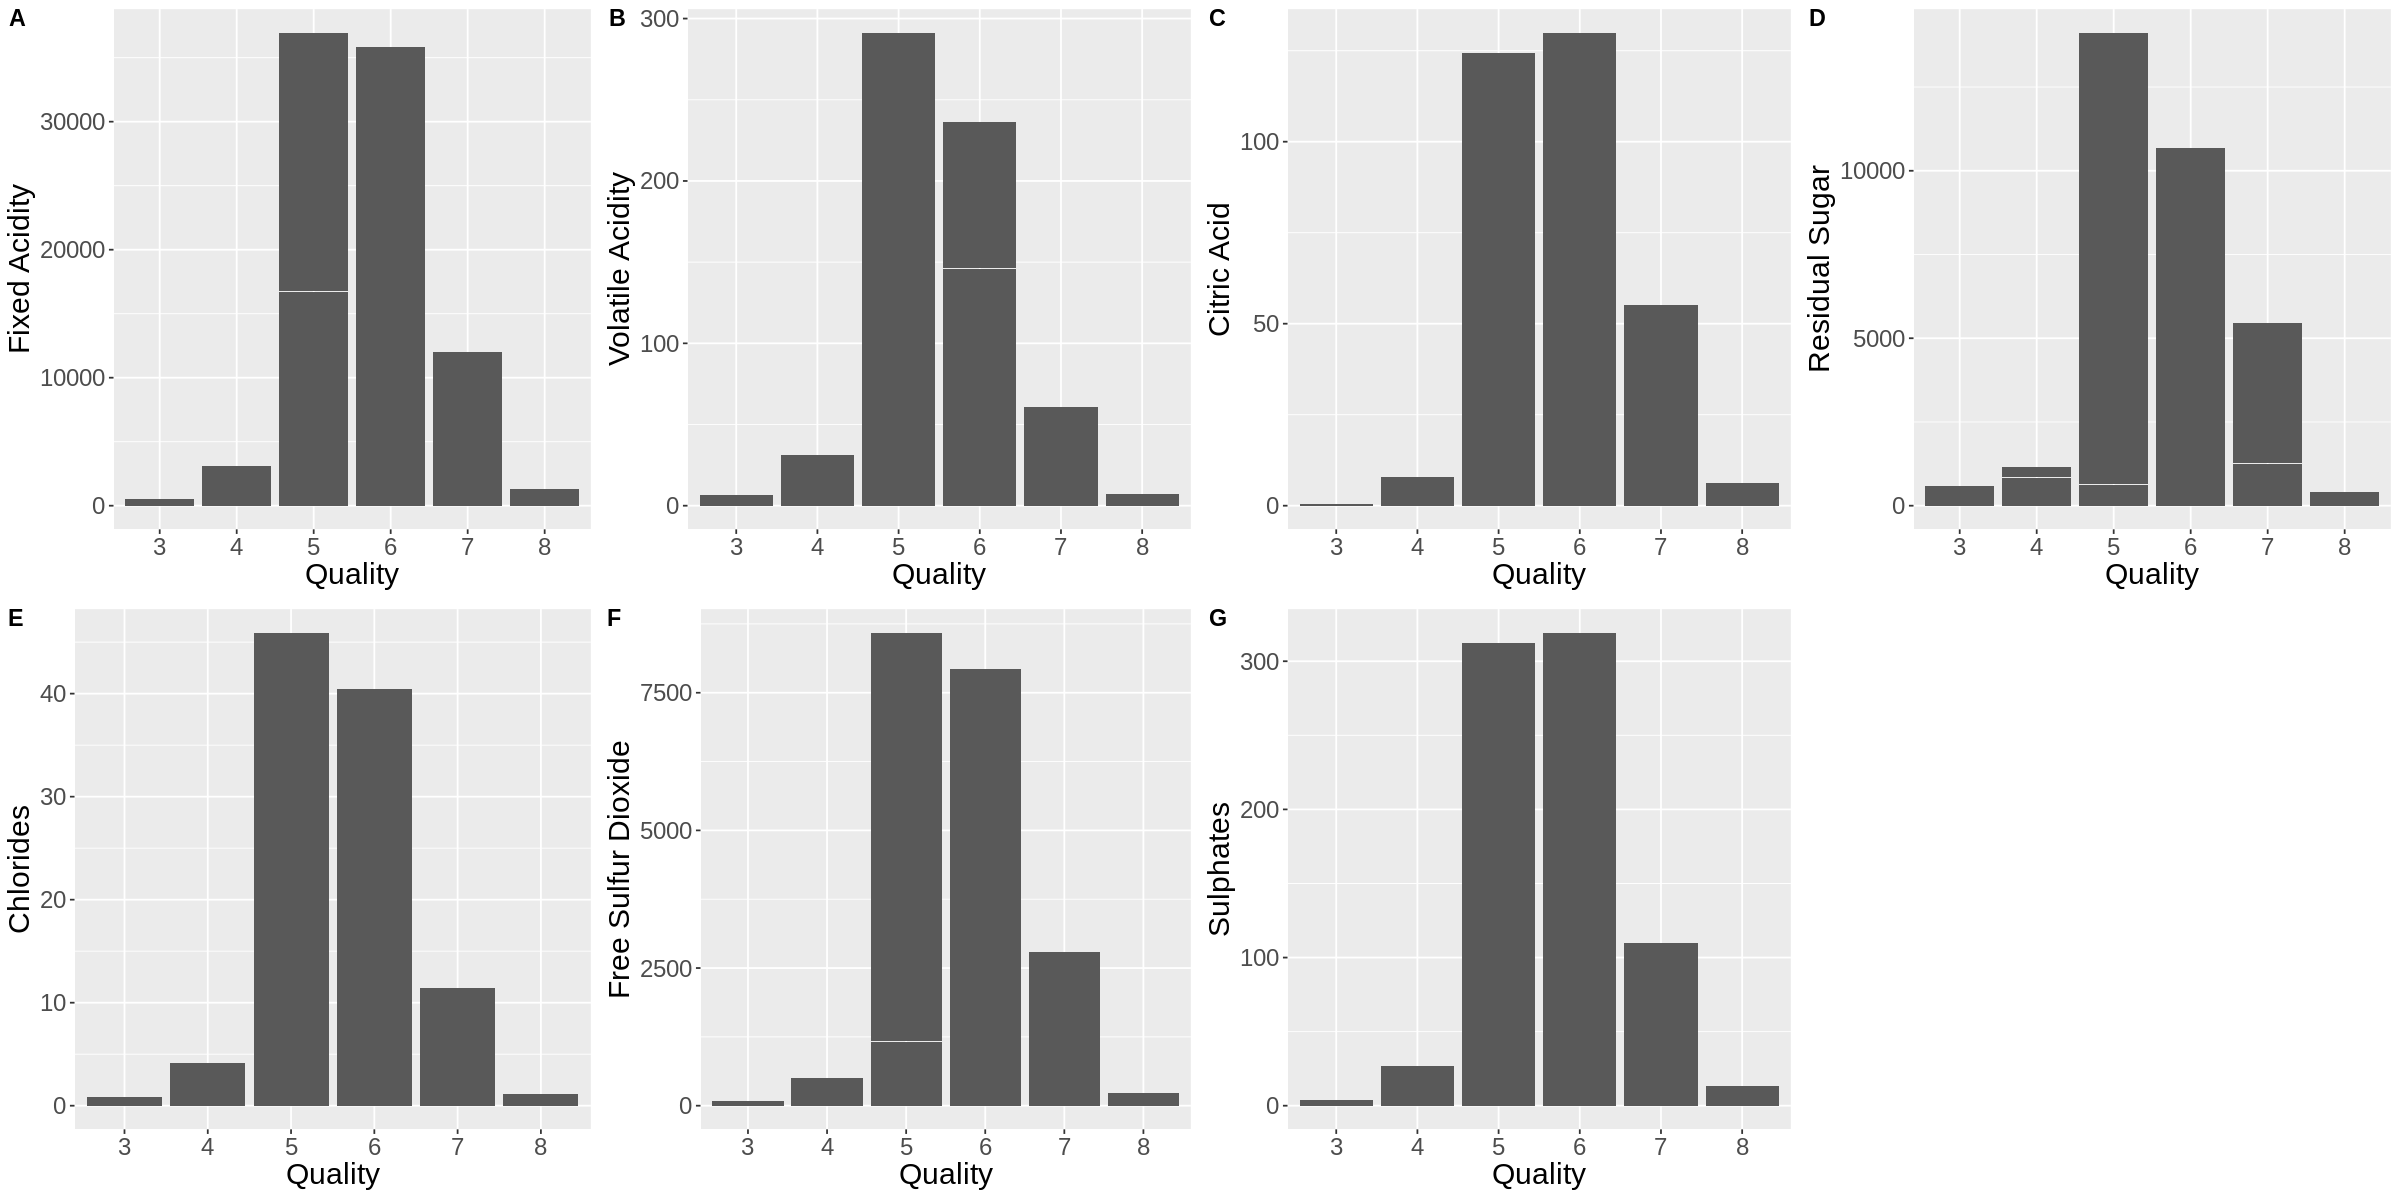

In [66]:
options(repr.plot.height = 10, repr.plot.width = 20)

fixed_acidity_plot <- ggplot(wine_train, aes(x = fixed.acidity, y = quality)) +
                geom_histogram(stat = "identity") +
                #facet_grid(rows = vars(quality))+
                labs(x = "Fixed Acidity", y = "Quality") +
                theme(text = element_text(size = 18)) +
                coord_flip()

volatile_acidity_plot <- ggplot(wine_train, aes(x = volatile.acidity, y = quality)) +
                geom_histogram(stat = "identity") +
                labs(x = "Volatile Acidity", y = "Quality") +
                theme(text = element_text(size = 18)) +
                coord_flip()

citric_acid_plot <- ggplot(wine_train, aes(x = citric.acid, y = quality)) +
                geom_histogram(stat = "identity") +
                labs(x = "Citric Acid", y = "Quality") +
                theme(text = element_text(size = 18)) +
                coord_flip()
 
residual_sugar_plot <- ggplot(wine_train, aes(x = residual.sugar, y = quality)) +
                geom_histogram(stat = "identity") +
                labs(x = "Residual Sugar", y = "Quality") +
                theme(text = element_text(size = 18)) +
                coord_flip()

chlorides_plot <- ggplot(wine_train, aes(x = chlorides, y = quality)) +
                geom_histogram(stat = "identity") +
                labs(x = "Chlorides", y = "Quality") +
                theme(text = element_text(size = 18)) +
                coord_flip()

free_sulfur_dioxide_plot <- ggplot(wine_train, aes(x = free.sulfur.dioxide, y = quality)) +
                geom_histogram(stat = "identity") +
                labs(x = "Free Sulfur Dioxide", y = "Quality") +
                theme(text = element_text(size = 18)) +
                coord_flip()

sulphates_plot <- ggplot(wine_train, aes(x = sulphates, y = quality)) +
                geom_histogram(stat = "identity") +
                labs(x = "Sulphates", y = "Quality") +
                theme(text = element_text(size = 18)) +
                coord_flip()

plot_grid(fixed_acidity_plot, volatile_acidity_plot, citric_acid_plot, residual_sugar_plot, chlorides_plot, free_sulfur_dioxide_plot, sulphates_plot,  
          labels = c("A", "B", "C", "D", "E", "F", "G"),
          ncol = 4, nrow = 2)

From reading these graphs, we can collect many useful information regarding to how each variables changes the overall quality of the wine. For example, the fixed acidity plot shows us that wines with quality of 3 contains amount ranging from 70 to 120, while wines with quality of 4 ranges from 0 to 125, and so on. 

## Method
We will create a scatterplot graph and assess how each variable changes the quality of wine, which has the biggest impact with the least change, then use classification to predict wine quality on a scale of 1-10. Columns with insignificant effect on the data (density, pH, alcohol, total sulfur dioxide) will be removed. Columns with significant impact (fixed acidity, volatile acidity, citric acid, residual sugar, sulfur dioxide, sulphates, and quality) will be kept. 
We will visualize the result to make another scatter plot graph. The y-axis will have the quality of the wine on a 1-10 scale and on the x-axis will have the other variable it is being compared to. This will provide several graphs visualizing each variable's impact on wine quality.

## Expected Outcomes and Significance
1. **What do we expect to find?**

We expect to determine the ideal ratio of wine factors to achieve the highest quality of vinho verde, and which variables are more consequential in comparison to others. There may be a “breaking point” within a variable, (a spot where the quality will drastically change after a certain threshold). 

2. **What impact could such findings have?**

Determining wine quality can promote wine testing and ensure safety within the food industry. It can inform consumers and motivate sellers to uphold a certain standard of quality. Furthermore, the quality of wine can serve as a reflection of its contents, which provides insight as to whether the wine is safe and follows food health and safety guidelines. 

3. **What future questions could this lead to?**

There may be further research into the factors not in this dataset, and whether certain variables can be compromised. It can also lead to further questions like “How do we cost effectively make high quality wine”, or wine producing the most sales, etc. 


## The k-nearest-neighbors Classification Model

1. Split the data
2. Create the model
3. Create the workflow
4. train the model
5. Test the model
6. Improve the model (??)


[need to include explanations between each step]

## Discussion

- summarize what you found
- discuss whether this is what you expected to find?
- discuss what impact could such findings have?
- discuss what future questions could this lead to?

## References

- At least 2 citations of literature relevant to the project (format is your choice, just be consistent across the references).
- Make sure to cite the source of your data as well.